# Introdução ao Reconhecimento de Padrões, 2020.2, UFC/DETI
## Trabalho 3

Aluno : Thyago Freitas da Silva <br>
Matrícula : 392035

In [267]:
import numpy as np
import operator
import collections
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt

### Funções úteis durante o decorrer do relatório

#### Calcular média de todas as colunas de uma matriz

In [96]:
def calc_mean(features):
    return np.mean(np.array(features),axis=0)

#### Transformar coluna com valores inválidos substituindo-os pela mediana da coluna

In [ ]:
def transform_column(column):
    transformed_column = np.array([0]*len(column))
    values = []
    for v in column:
        if v != '?':
            v = float(v)
            values.append(v)
    median = np.median(values)
    for index in range(len(column)):
        if column[index] == '?':
            transformed_column[index] = median
        else:
            transformed_column[index] = float(column[index])
    return transformed_column

#### Calcular matriz de espalhamento intra-clusters

In [224]:
def within_cluster(features,predicts,centroids):
    k = len(centroids)
    dimensions = features.shape[1]
    s_w = np.zeros((dimensions,dimensions))
    values = []
    for cent_idx, cent in enumerate(centroids):
        s_k = np.zeros((dimensions,dimensions))
        for pred in predicts:
            if pred == cent_idx:
                first_term = cent - pred
                values.append(np.outer(first_term,first_term))
    for v in values:
        s_w = np.add(s_w,v)
    return s_w

#### Calcular matriz de espalhamento entre clusters

In [225]:
def between_cluster(features,predicts,centroids):
    k = len(centroids)
    dimensions = features.shape[1]
    u = calc_mean(features)
    s_b = np.zeros((dimensions,dimensions))
    values = []
    for cent_idx, cent in enumerate(centroids):
        n_k = np.count_nonzero(predicts == cent_idx)
        first_term = cent - u
        sb_k = n_k*np.outer(first_term,first_term)
        values.append(sb_k)
    for v in values:
        s_b = np.add(s_b,v)
    return s_b

## Parte 0 : Banco de dados - Demartology

O banco de dados utilizado foi o "Demartology" que possui as seguintes características:

<ul>
<li>O arquivo CSV com os dados possui 35 colunas, sendo que a última coluna representa de forma numérica uma doenção demartológica.</li>
<li>A coluna 33 (band-like infiltrate) apresenta valores inválidos e que precisam ser removidos ou processados.</li>
<li>Temos 366 amostras no banco de dados.</li>
<li>A coluna 35 representa uma doença demartológica de forma numérica(1 à 6), sendo elas :</li>
    <ol>
        <li>psoriasis</li>
        <li>seboreic dermatitis</li>
        <li>lichen planus</li>
        <li>pityriasis rosea</li>
        <li>cronic dermatitis</li>
        <li>pityriasis rubra pilaris</li>
    </ol>
</ul>


In [12]:
data = pd.read_csv("./data/dermatology.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


## Parte 1 : K-Means
### Funcionamento do algoritmo

O algoritmo KMeans é um dos algoritmos mais famosos na classe de algoritmos de aprendizado de máquina não-supervisionado, onde ,diferente de algoritmos supervisionados onde o modelo aprende com exemplos previamente rotulados , nós não temos os resultados previamente estabelecidos durante a fase de treinamento e teste. O mesmo se enquadra na categoria de modelos de clusterização, ou agrupamento, onde o modelo irá caracterizar e agrupar dados com base em características que ele identifica como comum aos membros do cluster/grupo. Abaixo temos o passo a passo de como o algoritmo kmeans funciona em sua versão mais simples.


<ol>
<li>Escolher um número K que representa o numero de clusters e R como o número de interações do algoritmo.</li>
<li>Escolher aleatóriamente K amostras do banco de dados e tratá-las como os centróides.</li>
<li>Calcular a distância eculidiana de cada amostra para cada centróide escolhido.</li>
<li>Associar cada amostra ao centróide mais pŕoximo, formando grupos.</li>
<li>Após terminar o agrupamento, recalcular os centróides usando a média dos valores das amostras de cada grupo.
</li>
<li>Refazer a sequência de passos 3,4 e 5 R vezes ou até verificar que as amostras não mais mudam de centróides.</li>
</ol>

### Validação do número de clusters usando o índice de validação

Podemos validar se escolhemos um bom valor para K com base no índice de validação que pode ser calculado utilizando a seguinte equação :

$$ J_{a}(K) = traço(S^{-1}_{w}S_{b}) $$
$$ S_{w} = \sum_{k=1}^{K}\sum_{x\in C_{k}}^{K}(x - \mu_{k})(x - \mu_{k})^T $$
$$ S_{b} = \sum_{k=1}^{K}N_{k}(x - \mu_{k})(x - \mu_{k})^T $$

Onde :
    
<ul>
    <li> $ S_{w} $ é a matriz de espalhamento intra-clusters</li>
    <li> $ S_{b} $ é a matriz de espalhamento entre-clusters</li>
    <li> $ K $ é o número de clusters</li>
    <li> $ x $ é um membro do cluster $ C_{k} $</li>
    <li> $ \mu_{k} $ é o centróide do cluster $ C_{k} $</li>
    <li> $ \mu $ é a média de todo o banco de dados</li>
    <li> $ N_{k} $ é o número de membros no cluster $ C_{k} $</li>
</ul>

Quanto maior o número J, melhor é o valor de K.

### Implementacão do algoritmo "K-Means"

In [283]:
class KMeansClustering:
    def __init__(self, X, K, R, heuristic_for_initial_centroids='random'):
        self.K = K
        self.R = R
        self.n_examples = X.shape[0]
        self.n_features = X.shape[1]
        self.heuristic = heuristic_for_initial_centroids
        
    def initialize_centroids(self, X):
        centroids = np.zeros((self.K, self.n_features))
        for k in range(self.K):
            value = 0
            if self.heuristic == 'random':
                value = np.random.randint(self.n_examples)
            if self.heuristic == 'first':
                value = k
            centroids[k] = X[value]
        return centroids

    def calculate_clusters(self, X, centroids):
        clusters = [[] for _ in range(self.K)]
        for index_point, point in enumerate(X):
            distances_from_centroids = []
            for cent in centroids:
                dist = self.calc_distance_between_two_points(point,cent)
                distances_from_centroids.append(dist)
            closest_centroid = distances_from_centroids.index(min(distances_from_centroids))
            clusters[closest_centroid].append(index_point)
        return clusters

    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.K, self.n_features))
        for idx, cluster in enumerate(clusters):
            if len(cluster) == 0:
                new_centroid = X[np.random.randint(self.n_examples)]
            else:
                new_centroid = np.mean(X[cluster], axis=0)
            centroids[idx] = new_centroid
        return centroids

    def calc_distance_between_two_points(self,point1,point2):
        return np.linalg.norm(point1 - point2)

    def predict(self, clusters, X):
        predicts = np.zeros(self.n_examples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                predicts[sample_idx] = cluster_idx
        return predicts

    def fit(self, X):
        centroids = self.initialize_centroids(X)
        clusters = [[] for _ in range(self.K)]
        for it in range(self.R):
            clusters = self.calculate_clusters(X, centroids)
            old_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X)
            diff = centroids - old_centroids
            if not diff.any():
                break
        self.centroids = centroids
        return self.predict(clusters, X)

### Implementacão do algoritmo de índice de validação.

In [293]:
def J(features,R,K):
    result = []
    for k in range(2,K+1):
        values = 0
        for r in range(1,R+1):
            kmeans = KMeansClustering(features,k,r,'random')
            predicts = kmeans.fit(features)
            sw = within_cluster(features,predicts,kmeans.centroids)
            sb = between_cluster(features,predicts,kmeans.centroids)
            s = np.dot(np.linalg.inv(sw),np.transpose(sb))
            values += s.trace()
        print("Fim K {0}".format(k))
        result.append(values/R)
    return result

## Parte 1.1 : K-Means
### Avaliação usando o índice de validação de clusters

#### Leitura da base "demartology"

In [295]:
data = pd.read_csv("./data/dermatology.csv", header=None)
data = data.to_numpy()
data.shape

(366, 35)

#### Pré-processamento

Como informado anteriormente, a coluna 33 do banco de dados possui valores inválidos que atrapalham a execução do algoritmo, logo, afim de evitar a remoção da amostras que possuem esse problema, foi adotado a heurística de substituir os valores inválidos,pontos de interrogação,pela mediana da coluna. A mediana foi escolhida por ser menos sensível a outliers se comparada com a média, por exemplo.

In [296]:
data[:,33] = transform_column(data[:,33])

Agora precisamos isolar do conjunto de dados as features e a coluna que contém as classes.

In [297]:
features = data[:,:34]
classes = data[:,34]

#### Obtendo os valores de J para K indo de 2 até 15, e R igual a 30.

In [301]:
K = 15
R = 30
j_values = J(features,R,K)

Fim K 2
Fim K 3
Fim K 4
Fim K 5
Fim K 6
Fim K 7
Fim K 8
Fim K 9
Fim K 10
Fim K 11
Fim K 12
Fim K 13
Fim K 14
Fim K 15


#### Visualizando a variação de J com base no valor de K

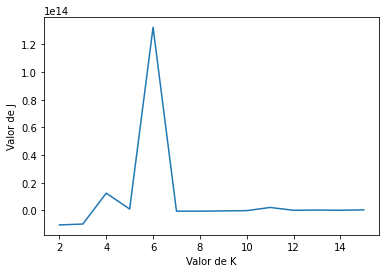

In [302]:
plt.plot(list(range(2,K+1)),j_values)
plt.ylabel("Valor de J")
plt.xlabel("Valor de K")
plt.show()

Sabemos que o conjunto de dados possui 6 classes, logo, teoricamente o maior valor de J deve estar associado a valores de K próximos de 6. Para obter o K associado ao maior J , basta encontrar o maior J na lista de valores retornados pelo algoritmo ,obter o índice desse elementro dentro da lista e somar 2, pois os indices na lista começam de 0 e nós utilizamos K igual a 2 como o primeiro valor para K.

In [303]:
print(j_values.index(max(j_values)) + 2)

6
